In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
import copy

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\Silica")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath, multidevice
from x403_crystals import get_crystal_in_delay_fixed_branch, get_crystals_in_delayed_branch
from x403_crystals import align_delay_fixed_branch, align_delayed_branch, get_light_path

# Define the pulse and grating

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Grating
# ---------------------------------------------------------------------------------------------------------- 
grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(0.25)
grating_list[0].set_b(0.25)
grating_list[1].set_a(0.25)
grating_list[1].set_b(0.25)


# -----------------------
#   Set spatial position
# -----------------------
# Grating_position_1
g_position_1 = np.array([252.70, 660.04, 140.04]) * 1000 + np.array([0, 652.5484, -2.9e6])
grating_list[0].set_surface_point(g_position_1)

g_position_2 = np.array([252.63, 659.55, 1065.14]) * 1000 + np.array([0, -652.5484, 2.1e6])
grating_list[1].set_surface_point(g_position_2)


# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 9.5  # keV
pre_length = 1e6    # Distance of the pulse from the first grating

# Set up the pulse
FWHM = 50 # (um)

my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[1., 0., 0.],
                              sigma_x=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_y=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_z=1.,
                              x0=g_position_1 - np.array([0., 0., pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                      Grating splitting angle
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(grating_list[0].base_wave_vector[1] / my_pulse.klen0)  # This is the deviation angle.

# Define and align crystals

In [59]:
lattice_distance = 1.9201 * 1e-4   # Lattice plane distance in um

chi_dict = {"chi0": complex(-0.10826E-04, 0.18209E-06 ),
            "chih_sigma": complex(0.65800E-05, -0.17530E-06  ),
            "chihbar_sigma": complex(0.65800E-05, -0.17530E-06  ),
            "chih_pi": complex(0.50600E-05, -0.13313E-06),
            "chihbar_pi": complex(0.50600E-05, -0.13313E-06)
            }

# Crystal in Delayed branch
crystal_list_1 = get_crystals_in_delayed_branch(asymmetric_angles=np.deg2rad(np.array([0,-5,5,0,
                                                                                       0,5,-5,0])),
                                               lattice_distance=lattice_distance,
                                               chi_dict=chi_dict)

# Crystal in Delay fixed branch
crystal_list_2 = get_crystal_in_delay_fixed_branch(lattice_distance=lattice_distance,
                                               chi_dict=chi_dict)

###################################################################
#    Align the crystals
###################################################################
# Bragg angle
bragg = np.radians(19.868)

#################################################################
#        Delayed Branch
#################################################################
crystal_list_1 = align_delayed_branch(delayed_branch_crystals = crystal_list_1,
                                      angle_offset = dtheta,
                                      bragg = bragg + 530e-6,
                                      tweak = np.array([0,-1035e-6,-1035e-6,0]))

#################################################################
#        Delay-fixed Branch
#################################################################
crystal_list_2 = align_delay_fixed_branch(delay_fixed_branch_crystals = crystal_list_2,
                                          angle_offset = -dtheta,
                                          bragg =  bragg + 533e-6,
                                          tweak = 1045e-6)

# Tune crystal positions to achieve spatial and temporal overlap

In [60]:
t23_motion = 0.
t5_motion = -255.

(new_path_upper,
 new_path_lower,
 new_crystal,
 new_crystal_lower) = get_light_path(ref_crystal_up = crystal_list_1,
                                     ref_crystal_low = crystal_list_2,
                                     ref_grating = grating_list,
                                     ref_pulse = my_pulse,
                                     shift_upper = np.array([2325.5 - 360,] * 2 +
                                                            [-2325.5 - 360,] * 2 + 
                                                            [0,] * 2 +
                                                            [3961 + t5_motion,] * 2),
                                     shift_lower = [0,] * 2 + [900,]*2)

In [61]:
print("-------------------------------")
print("Grating position: ")
print("New upper: {:.4f}".format(new_path_upper[0][-2, 1]))
print("New lower: {:.4f}".format(new_path_lower[0][-2, 1]))

print("-------------------------------")
print("Light Path position: ")
print("New upper: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])))
print("New lower: {:.4f}".format(util.get_total_path_length(new_path_lower[0][:-1])))
print("Difference: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])
                                 -util.get_total_path_length(new_path_lower[0][:-1])))

-------------------------------
Grating position: 
New upper: 660502.4054
New lower: 660368.6155
-------------------------------
Light Path position: 
New upper: 6959805.1683
New lower: 6959732.0458
Difference: 73.1225


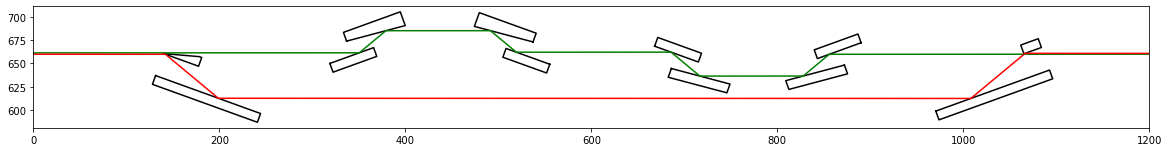

In [62]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for x in range(8):
    ax.plot([new_crystal[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')
    
for x in range(4):
    ax.plot([new_crystal_lower[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal_lower[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')

ax.plot(new_path_upper[0][:,2]/1000,
        new_path_upper[0][:,1]/1000,'g')

ax.plot(new_path_lower[0][:,2]/1000,
        new_path_lower[0][:,1]/1000,'r')

ax.set_aspect("equal")
ax.set_xlim([0, 1200])

plt.show()

# Get  reflectivity curve

In [63]:
kin_number = 2 ** 12

# Get energy array
energy_range = 50e-3  # 10eV
energy_array = np.linspace(energy_center - energy_range/2, energy_center + energy_range/2, num=kin_number)

# Get the kin_array
kin_array = np.zeros((kin_number, 3))
kin_array[:,2] = util.kev_to_wave_number(energy_array)

# Get the reflectivity curve of the delayed branch
# Add the first grating
kin_array[:,1] = grating_list[0].base_wave_vector[1]
(delayed_total_efficiency_holder,
 delayed_efficiency_holder,
 delayed_kout_holder) = multidevice.get_output_efficiency_curve(device_list=new_crystal,
                                                                kin_list=kin_array)

# Get the reflectivity curve of the delay fixed branch
kin_array[:,1] = -grating_list[0].base_wave_vector[1]
(delay_fixed_total_efficiency_holder,
 delay_fixed_efficiency_holder,
 delay_fixed_kout_holder) = multidevice.get_output_efficiency_curve(device_list=new_crystal_lower,
                                                                kin_list=kin_array)

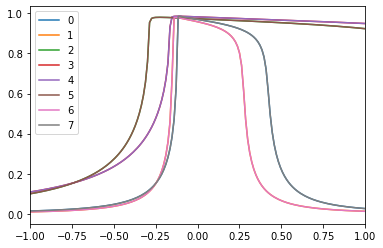

In [64]:
for x in range(8):
    plt.plot((energy_array - energy_center) * 1000, delayed_efficiency_holder[:,x], label="{}".format(x))
    
plt.xlim([-1, 1])
plt.legend()
plt.show()

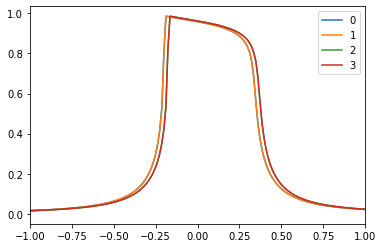

In [65]:
for x in range(4):
    plt.plot((energy_array - energy_center) * 1000, delay_fixed_efficiency_holder[:,x], label="{}".format(x))
    
plt.xlim([-1, 1])
plt.legend()
plt.show()

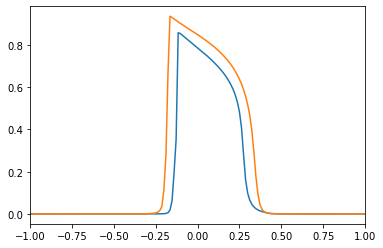

In [66]:
plt.plot((energy_array - energy_center) * 1000, delayed_total_efficiency_holder)
plt.plot((energy_array - energy_center) * 1000, delay_fixed_total_efficiency_holder)
plt.xlim([-1, 1])

plt.show()